Datos originales: (1101, 16)
Distribución original target (tras limpiar): Counter({5: 857, 10: 108, 15: 40, 20: 40, 30: 22, 40: 8, 25: 5, 50: 5, 999: 3, 45: 3, 80: 3, 60: 2, 90: 2, 35: 1, 75: 1, 70: 1})
Distribución original por clases: Counter({'Corto': 1005, 'Medio': 79, 'Largo': 17})

Antes de balancear: Counter({'Corto': 1005, 'Medio': 79, 'Largo': 17})
Después de balancear: Counter({'Corto': 1005, 'Medio': 1005, 'Largo': 1005})

 MÉTRICAS DE REGRESIÓN
R2: 0.799 | MAE: 6.101 | RMSE: 9.218

 MÉTRICAS DE CLASIFICACIÓN
Accuracy: 0.836
Precision (macro): 0.849
Recall (macro): 0.836
F1-score (macro): 0.834
Cohen Kappa: 0.754

 MATRIZ DE CONFUSIÓN:
[[161   1  39]
 [  0 200   1]
 [  2  56 143]]

 CLASIFICACION REPORTE
              precision    recall  f1-score   support

       Corto       0.99      0.80      0.88       201
       Largo       0.78      1.00      0.87       201
       Medio       0.78      0.71      0.74       201

    accuracy                           0.84       603
   

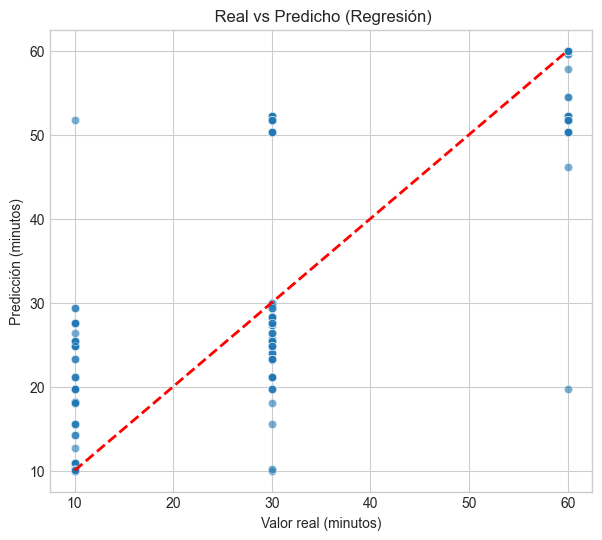

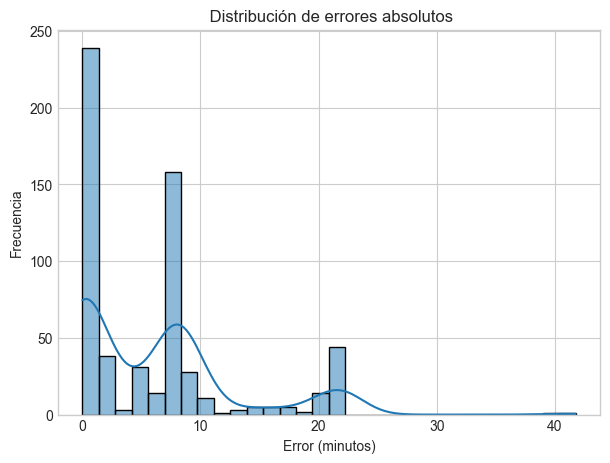

c:\Parklytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


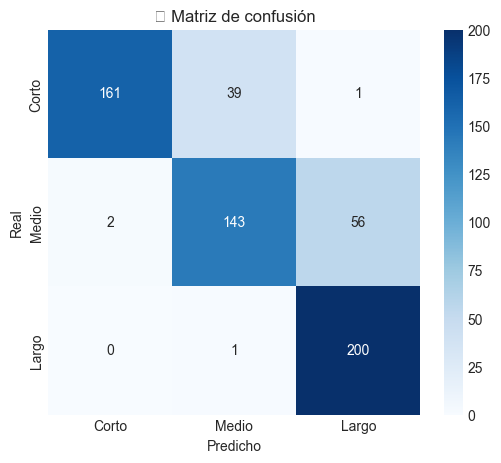

<Figure size 800x500 with 0 Axes>

c:\Parklytics\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128203 (\N{CLIPBOARD}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


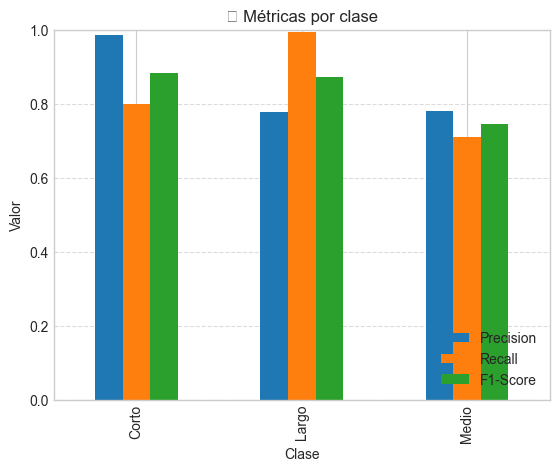

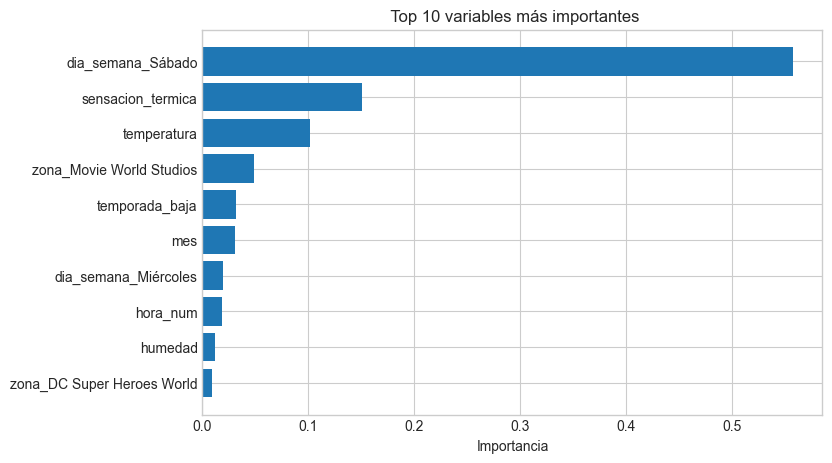


💾 Modelo y scaler guardados en /models/
📁 Métricas guardadas en metrics/metricas_modelo.json


In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, cohen_kappa_score
)
from imblearn.over_sampling import SMOTE
import joblib
import json


#  Cargar y preparar datos

df = pd.read_csv("df_model.csv")

# Asegurarnos de que la columna 'tiempo_espera' existe
if 'tiempo_espera' not in df.columns:
    raise ValueError(" La columna 'tiempo_espera' no existe en el archivo CSV.")

# Eliminar filas con nulos en el target
df = df.dropna(subset=['tiempo_espera'])

# Variables predictoras y objetivo
X = df.drop(columns=['tiempo_espera'])
y = df['tiempo_espera']

print("Datos originales:", X.shape)
print("Distribución original target (tras limpiar):", Counter(y))


#  Crear clases (segmentación del target)

def clasificar_tiempo(t):
    if 5 <= t <= 15:
        return 'Corto'
    elif 15 < t <= 45:
        return 'Medio'
    else:
        return 'Largo'

y_class = y.apply(clasificar_tiempo)
print("Distribución original por clases:", Counter(y_class))

# ========================================
# 3️⃣ Balancear clases con SMOTE
# ========================================
smote = SMOTE(random_state=42)
X_res, y_class_res = smote.fit_resample(X, y_class)

print("\nAntes de balancear:", Counter(y_class))
print("Después de balancear:", Counter(y_class_res))

# ========================================
# 4️⃣ Escalado y split
# ========================================
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X_res, y_class_res, test_size=0.2, random_state=42, stratify=y_class_res
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ========================================
# 5️⃣ Entrenar modelo (Random Forest)
# ========================================
model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train_class.map({'Corto': 10, 'Medio': 30, 'Largo': 60}))  # valores representativos

# ========================================
# 6️⃣ Predicciones
# ========================================
y_pred = model.predict(X_test)

# Convertir predicciones numéricas a clases
bins = [0, 15, 45, np.inf]
labels = ['Corto', 'Medio', 'Largo']
y_pred_class = pd.cut(y_pred, bins=bins, labels=labels, include_lowest=True)

# ========================================
# 7️⃣ Métricas de regresión
# ========================================
y_test_reg = y_test_class.map({'Corto': 10, 'Medio': 30, 'Largo': 60})
r2 = r2_score(y_test_reg, y_pred)
mae = mean_absolute_error(y_test_reg, y_pred)
rmse = np.sqrt(mean_squared_error(y_test_reg, y_pred))

print("\n MÉTRICAS DE REGRESIÓN")
print(f"R2: {r2:.3f} | MAE: {mae:.3f} | RMSE: {rmse:.3f}")

# ========================================
# 8️⃣ Métricas de clasificación
# ========================================
y_test_class = pd.Series(y_test_class).astype(str)
y_pred_class = pd.Series(y_pred_class).astype(str)

acc = accuracy_score(y_test_class, y_pred_class)
prec = precision_score(y_test_class, y_pred_class, average='macro', zero_division=0)
rec = recall_score(y_test_class, y_pred_class, average='macro', zero_division=0)
f1 = f1_score(y_test_class, y_pred_class, average='macro', zero_division=0)
kappa = cohen_kappa_score(y_test_class, y_pred_class)

print("\n MÉTRICAS DE CLASIFICACIÓN")
print(f"Accuracy: {acc:.3f}")
print(f"Precision (macro): {prec:.3f}")
print(f"Recall (macro): {rec:.3f}")
print(f"F1-score (macro): {f1:.3f}")
print(f"Cohen Kappa: {kappa:.3f}")

print("\n MATRIZ DE CONFUSIÓN:")
print(confusion_matrix(y_test_class, y_pred_class))

print("\n CLASIFICACION REPORTE")
print(classification_report(y_test_class, y_pred_class))

# ============================================
# 9️⃣ Tabla de métricas por clase
# ============================================
from sklearn.metrics import precision_recall_fscore_support

classes = sorted(y_test_class.unique())
precisions, recalls, f1s, _ = precision_recall_fscore_support(
    y_test_class, y_pred_class, labels=classes, zero_division=0
)

df_metrics = pd.DataFrame({
    'Clase': classes,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1s
}).round(3)

print("\n MÉTRICAS POR CLASE")
print(df_metrics.to_string(index=False))

# ==========================================
# 📊 VISUALIZACIONES COMPLEMENTARIAS
# ==========================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

plt.style.use('seaborn-v0_8-whitegrid')

# 1️⃣ Gráfico real vs predicho (regresión)
plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test_reg, y=y_pred, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.title(' Real vs Predicho (Regresión)')
plt.xlabel('Valor real (minutos)')
plt.ylabel('Predicción (minutos)')
plt.show()

# 2️⃣ Distribución de errores absolutos
errores = np.abs(y_test_reg - y_pred)
plt.figure(figsize=(7, 5))
sns.histplot(errores, bins=30, kde=True)
plt.title(' Distribución de errores absolutos')
plt.xlabel('Error (minutos)')
plt.ylabel('Frecuencia')
plt.show()

# 3️⃣ Matriz de confusión (clasificación)
conf_matrix = confusion_matrix(y_test_class, y_pred_class, labels=labels)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('🧩 Matriz de confusión')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

# 4️⃣ Gráfico de barras con métricas por clase
plt.figure(figsize=(8, 5))
df_metrics.set_index('Clase')[['Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.title('📋 Métricas por clase')
plt.xlabel('Clase')
plt.ylabel('Valor')
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 5️⃣ Importancia de variables (si existe en el modelo)
try:
    importances = model.feature_importances_
    feature_names = X.columns
    sorted_idx = np.argsort(importances)[-10:]  # top 10 features

    plt.figure(figsize=(8, 5))
    plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
    plt.title(' Top 10 variables más importantes')
    plt.xlabel('Importancia')
    plt.show()
except Exception as e:
    print("No se pudo mostrar importancia de variables:", e)

    # ====================================================
# 9️⃣ GUARDADO DEL MODELO
# ====================================================
joblib.dump(model, "../models/modelo_randomforest.pkl")
joblib.dump(scaler, "../models/scaler.pkl")

print("\n💾 Modelo y scaler guardados en /models/")


# ====================================================
# 🔟 GUARDAR MÉTRICAS PARA OTROS MÓDULOS (FASE 6-7)
# ====================================================
metricas = {
    "r2": float(r2),
    "mae": float(mae),
    "rmse": float(rmse),
    "accuracy": float(acc),
    "precision_macro": float(prec),
    "recall_macro": float(rec),
    "f1_macro": float(f1),
    "kappa": float(kappa)
}

json.dump(metricas, open("../metrics/metricas_modelo.json", "w"), indent=4)

print("📁 Métricas guardadas en metrics/metricas_modelo.json")


# ====================================================
# 1️⃣1️⃣ FUNCIÓN DE PREDICCIÓN PARA STREAMLIT / INSIGHTS
# ====================================================
def predict_wait_time(input_dict):
    df_input = pd.DataFrame([input_dict])
    df_scaled = scaler.transform(df_input)
    pred = model.predict(df_scaled)[0]
    clase = clasificar_tiempo(pred)
    return {"minutos_predichos": pred, "clase": clase}




In [69]:

import pandas as pd
import numpy as np


ejemplo = pd.DataFrame([{
    'abierta': 1,                     
    'mes': 10,                          
    'fin_de_semana': 1,               
    'temperatura': 21.0,              
    'humedad': 60.0,                   
    'sensacion_termica': 20.0,         
    'codigo_clima': 0,                 
    'hora_num': 17,                     
    'zona_DC Super Heroes World': 1,   
    'zona_Movie World Studios': 0,     
    'zona_Old West Territory': 0,      
    'dia_semana_Miércoles': 0,         
    'dia_semana_Sábado': 1,            
    'dia_semana_Thursday': 0,          
    'dia_semana_Viernes': 0,           
    'temporada_baja': 0                
}])


ejemplo_scaled = scaler.transform(ejemplo)


prediccion_tiempo = model.predict(ejemplo_scaled)[0]
print(f" Tiempo predicho (minutos): {prediccion_tiempo:.2f}")


def clasificar_tiempo(t):
    if 5 <= t <= 15:
        return 'Corto'
    elif 15 < t <= 45:
        return 'Medio'
    else:
        return 'Largo'

prediccion_clase = clasificar_tiempo(prediccion_tiempo)
print(f" Clase predicha: {prediccion_clase}")


 Tiempo predicho (minutos): 41.31
 Clase predicha: Medio
